In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../m2py/networks/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OFET processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/OFET_total_df.xlsx')
print (total_df.shape)
total_df.head()

(74, 24)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,...,Perim_stdev,GMM_label,mu_lin_avg,mu_lin_sd,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,0,10,100,3,1,5.856501,3.244681,3.075720,1.985903,0.760772,...,8.561025,1,0.027205,0.000495,0.751935,0.002915,83456.5773,1672.053023,-18.385927,0.266716
1,1,10,100,3,3,7.550006,3.905505,4.143006,2.309477,0.773807,...,11.215483,1,0.038410,0.000741,0.748463,0.001580,133461.6840,2586.760156,-19.986533,0.160197
2,2,10,100,3,5,8.577824,5.768438,4.665343,3.193484,0.773831,...,13.063983,1,0.025188,0.000154,0.747956,0.008564,132094.0970,4613.253520,-20.648421,0.404781
3,3,10,100,3,5,5.914614,2.647315,3.398168,1.667982,0.745994,...,7.433700,1,0.025188,0.000154,0.747956,0.008564,132094.0970,4613.253520,-20.648421,0.404781
4,4,10,100,4,3,7.179457,3.464021,3.944406,2.070579,0.771835,...,9.691014,1,0.032493,0.000350,0.732737,0.001381,245995.6098,7239.904390,-21.035315,0.023485


In [103]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(total_df['mu_lin_avg'])*0.8*0.7) # 90% of x_train samples
learning_rate = 0.001

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [95]:
X = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MajorAL_stdev', 'MinorAL_avg',
              'MinorAL_stdev', 'Ecc_avg', 'Ecc_stdev', 'Orient_avg', 'Orient_stdev', 'Perim_avg',
              'Perim_stdev', 'GMM_label']] #input features used to make prediction
Y = total_df[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [105]:
x_train, x_train_key = nuts.df_Gaussian_normalize(x_train)
y_train, y_train_key = nuts.df_Gaussian_normalize(y_train)

x_test, x_test_key = nuts.df_Gaussian_normalize(x_test)
y_test, y_test_key = nuts.df_Gaussian_normalize(y_test)

mu_train = y_train['mu_lin_avg']
mu_test = y_test['mu_lin_avg']
r_train = y_train['r_lin_avg']
r_test = y_test['r_lin_avg']
on_off_train = y_train['on_off_avg']
on_off_test = y_test['on_off_avg']
vt_train = y_train['Vt_avg']
vt_test = y_test['Vt_avg']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
mu_train_tensor = torch.tensor(mu_train.values.astype(np.float32))
r_train_tensor = torch.tensor(r_train.values.astype(np.float32))
on_off_train_tensor = torch.tensor(on_off_train.values.astype(np.float32))
vt_train_tensor = torch.tensor(vt_train.values.astype(np.float32))
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, mu_train_tensor,
                                              r_train_tensor, on_off_train_tensor,
                                              vt_train_tensor) #create tensor with features and targets
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, drop_last = True) #create iterable dataset with batches

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
mu_test_tensor = torch.tensor(mu_test.values.astype(np.float32))
r_test_tensor = torch.tensor(r_test.values.astype(np.float32))
on_off_test_tensor = torch.tensor(on_off_test.values.astype(np.float32))
vt_test_tensor = torch.tensor(vt_test.values.astype(np.float32))
test_tensor = torch.utils.data.TensorDataset(x_test_tensor, mu_test_tensor,
                                              r_test_tensor, on_off_test_tensor,
                                              vt_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [106]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (mu_lin, r_lin, on_off, Vt)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OFET_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [107]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
mu_train_epoch_losses = []
r_train_epoch_losses = []
on_off_train_epoch_losses = []
vt_train_epoch_losses = []

test_epoch_losses = []
mu_test_epoch_losses = []
r_test_epoch_losses = []
on_off_test_epoch_losses = []
vt_test_epoch_losses = []

mu_test_epoch_accuracies = []
r_test_epoch_accuracies = []
on_off_test_epoch_accuracies = []
vt_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OFET_NN1/"
    model_name = "OFET_NN1"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, mu_train_loss, r_train_loss, on_off_train_loss, vt_train_loss = train.train_OFET_df_model(model = model,
                                                                                                                 training_data_set = training_data_set,
                                                                                                                 optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    mu_train_epoch_losses.append(mu_train_loss)
    r_train_epoch_losses.append(r_train_loss)
    on_off_train_epoch_losses.append(on_off_train_loss)
    vt_train_epoch_losses.append(vt_train_loss)
    
    test_loss, mu_test_loss, r_test_loss, on_off_test_loss, vt_test_loss, mu_acc, r_acc, on_off_acc, vt_acc = test.eval_OFET_df_model(model = model,
                                                                                                                                      testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    mu_test_epoch_losses.append(mu_test_loss)
    r_test_epoch_losses.append(r_test_loss)
    on_off_test_epoch_losses.append(on_off_test_loss)
    vt_test_epoch_losses.append(vt_test_loss)
    
    mu_test_epoch_accuracies.append(mu_acc)
    r_test_epoch_accuracies.append(r_acc)
    on_off_test_epoch_accuracies.append(on_off_acc)
    vt_test_epoch_accuracies.append(vt_acc)
    
#     if epoch in save_epochs:
 
#         nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)
        #TODO: update for branched OPV specific function?

On epoch  0
Total Epoch Testing Loss = 0.21196092665195465
Total Epoch Testing Accuracy: mu = -531.5363396331668
                              r = 11.470293353001276
                              on_off = -117.9187333583832
                              Vt = -70.28920888900757
On epoch  1
Total Epoch Testing Loss = 0.05185370892286301
Total Epoch Testing Accuracy: mu = -471.11502954736346
                              r = 13.067488123973211
                              on_off = -116.20199839274088
                              Vt = -68.6295775572459
On epoch  2
Total Epoch Testing Loss = 0.0781642347574234
Total Epoch Testing Accuracy: mu = -418.96871355672675
                              r = 14.266541153192518
                              on_off = -114.48000113169353
                              Vt = -67.45867927869162
On epoch  3
Total Epoch Testing Loss = 0.21918195486068726
Total Epoch Testing Accuracy: mu = -367.6199322442214
                              r = 16.31338626146316

/Users/wesleytatum/Desktop/m2py/m2py_Github/m2py/m2py/networks/physically_informed_loss_functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error = torch.neg(torch.tensor(y))


Total Epoch Testing Loss = 0.4282890856266022
Total Epoch Testing Accuracy: mu = -178.2649995883306
                              r = 28.01481862862905
                              on_off = -100.98400115966797
                              Vt = -63.03010900815328
On epoch  16
Total Epoch Testing Loss = 0.0827939510345459
Total Epoch Testing Accuracy: mu = -179.3124657869339
                              r = 28.676058848698933
                              on_off = -100.82288265228271
                              Vt = -63.65338325500488
On epoch  17
Total Epoch Testing Loss = 0.36271220445632935
Total Epoch Testing Accuracy: mu = -164.09858783086142
                              r = 29.782883723576862
                              on_off = -101.23116493225098
                              Vt = -64.4101099173228
On epoch  18
Total Epoch Testing Loss = 0.07274648547172546
Total Epoch Testing Accuracy: mu = -147.96269933382672
                              r = 30.783028999964397
        

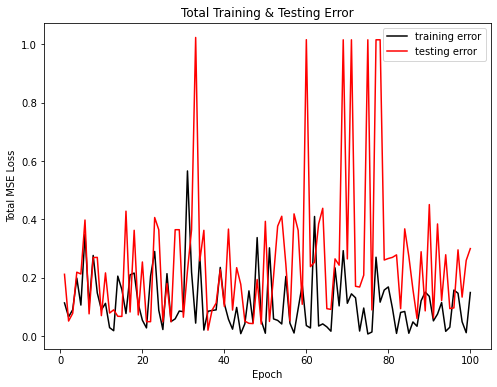

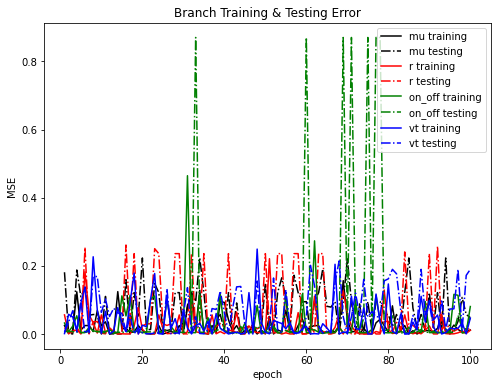

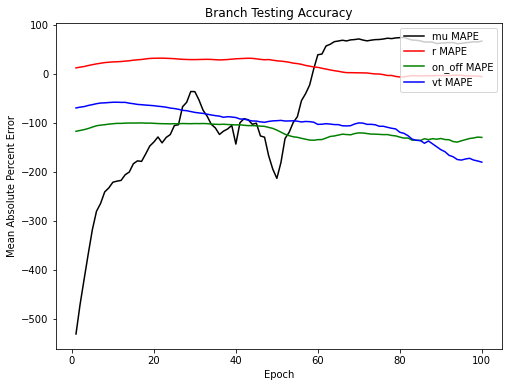

In [108]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OFET_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                       mu_train_epoch_losses, mu_test_epoch_losses,
                       r_train_epoch_losses, r_test_epoch_losses,
                       on_off_train_epoch_losses, on_off_test_epoch_losses,
                       vt_train_epoch_losses, vt_test_epoch_losses)

nuts.plot_OFET_df_accuracies(epochs, mu_test_epoch_accuracies, r_test_epoch_accuracies, 
                             on_off_test_epoch_accuracies, vt_test_epoch_accuracies)

In [109]:
model.eval()

with torch.no_grad():
    for inputs, mu_labels, r_labels, on_off_labels, vt_labels in testing_data_set:
        inputs = inputs.to(device)
        mu_labels = mu_labels.to(device)
        r_labels = r_labels.to(device)
        on_off_labels = on_off_labels.to(device)
        vt_labels = vt_labels.to(device)

        mu_out, r_out, on_off_out, vt_out = model(inputs)


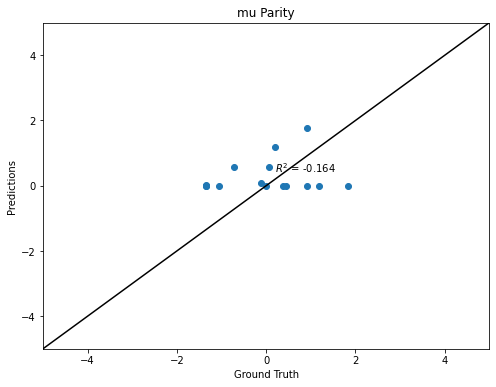

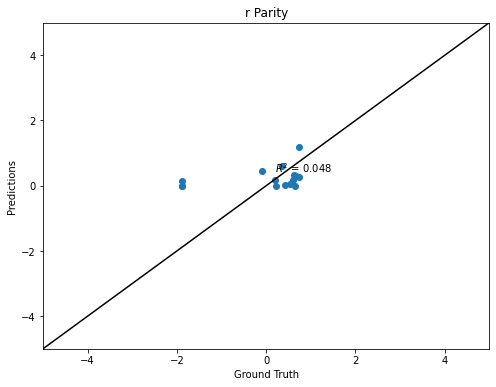

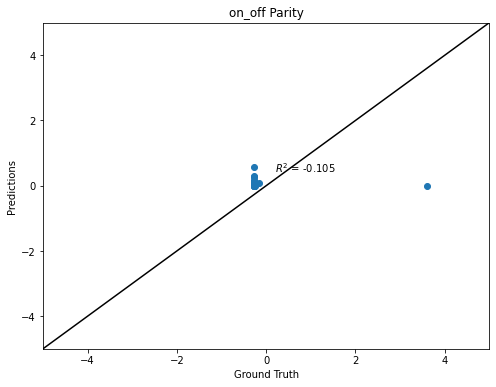

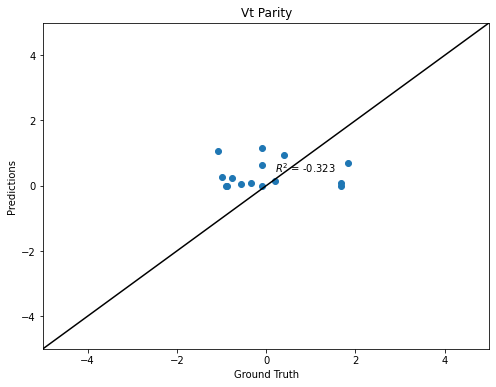

In [110]:
nuts.plot_OFET_parity(mu_labels, mu_out, r_labels, r_out,
                      on_off_labels, on_off_out, vt_labels, vt_out)